# Supporting code to generate results included in the `Quantifying participation biases on social media` paper.

In [13]:
%run Utilities.ipynb

In [14]:
import json
import pandas as pd
import numpy as np
from scipy import stats 
from scipy.stats import dirichlet,beta,bernoulli,multinomial,uniform,norm,invgamma
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import sys,os
import matplotlib.pyplot as plt
import pickle
from random import seed
from random import randint
import seaborn as sns
from sklearn.manifold import MDS as mds
from tqdm import tqdm
import plotly.graph_objects as go
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as mtick

sns.set(color_codes=True)
sns_c = sns.color_palette(palette='deep')
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=3)

%matplotlib inline

# Survey simulator settings

In [15]:
# list of target demographics
num_demographics = 2
dems = ['x_dem{}'.format(i+1) for i in range(num_demographics)]
# number of topics to run surveys for
num_surveys = 500
f = 4
params = {'x_dem1_ideol0': beta(f*24.3, f*5.5),
 'x_dem2_ideol0': beta(f*11.40, f*2.7),
 'x_dem1_ideol1': beta(f*5.45, f*8.12),
 'x_dem2_ideol1': beta(f*5.19, f*6.42)}

# prior to sample pro stance for ideol0, will be less than 0.5
beta_prior_ideol0 = beta(50,70) 
# prior to sample pro stance for ideol1, will be greater than 0.5
beta_prior_ideol1 = beta(120,60)
# prior for sampling the error margin in surveys
uniform_prior = uniform(0.03,0.01) 

# Survey simulator

Define pro stance for each demographic for each ideology, for a given topic

In [16]:
demmap = {'dem1':'Male','dem2':'Female'}

In [17]:
# generates a certain number of surveys indexed by topic, and gets the response rates for each demographic subgroup
# along with their respective error margins
survey_dem_x = {}
survey_dem_error_margins = {}
for s in range(num_surveys):
    survey_topic_name = 'survey{}'.format(s)
    # generate response rates
    topic_dem_x = {}
    topic_dem_error_margins = {}
    for g in dems:
        # for a given topic: get the response rates for a given demographic subgroup (pro abortion - women - 0.61)
        topic_dem_x[g+'_ideol0'] = params[g+'_ideol0'].rvs(1)[0] 
        topic_dem_x[g+'_ideol1'] = params[g+'_ideol1'].rvs(1)[0] 
        
        topic_dem_error_margins[g+'_ideol0'] = np.round(uniform_prior.rvs(1)[0],len(dems))
        topic_dem_error_margins[g+'_ideol1'] = np.round(uniform_prior.rvs(1)[0],len(dems))
        
    survey_dem_x[survey_topic_name] = topic_dem_x
    survey_dem_error_margins[survey_topic_name] = topic_dem_error_margins

In [18]:
df_survey_dem_x = pd.DataFrame.from_dict(survey_dem_x).transpose()

In [19]:
demnames = ['L-Male','C-Male','L-Female','C-Female']

# Social Media Simulator Settings

In [20]:
# need to pick this from general population distribution - will be set as prior for inference
pop_dem_dist = {'dem1_ideol0':0.25,'dem2_ideol0':0.25,
                'dem1_ideol1':0.25,'dem2_ideol1':0.25}
# SM population distribution for each demographic - only used for simulation
sm_dem_dist = {'dem1':0.50,'dem2':0.50} # - gender division (from Pew)
# Number of SM users
num_users = 20000

In [21]:
# Inference parameter settings
# Prior estimate for the SM demographic distribution (can use general population distribution for this)
prior_sm_dem_dist = np.array(list(pop_dem_dist.values()))
# Number of experiment runs - to get standard deviation across runs
num_expts = 10
# Number of surveys per topic considered for each inference run
num_surveys_per_topic = 30
# Variance of the q-distribution for importance sampling
qvar = 5
# Variance of the p-distribution for importance sampling
pvar = 100 #100

## Participation BIAS RESULTS 

Use the code below for generating Figure 4 - 7.

Vary participation bias and keep platform bias fixed. Use the following parameter settings:

| Figure | _platform_bias_ | _noise_level_ | _var_prior_ |
| --- | --- | --- | --- |
| 4 | 0.5 | 0.05 | 0.005|
|  |  |  |  |
| 5(a) | 0.5 | 0.005 | 0.005|
| 5(b) | 0.5 | 0.01 | 0.005|
| 5(c) | 0.5 | 0.05 | 0.005|
| 5(d) | 0.5 | 0.1 | 0.005|
|  |  |  |  |
| 6(a) | 0.5 | 0.05 | 0.005|
| 6(b) | 0.5 | 0.05 | 0.001|
| 6(c) | 0.5 | 0.05 | 0.05|
| 6(d) | 0.5 | 0.05 | 0.01|
|  |  |  |  |
| 7(a) | 0.1 | 0.05 | 0.005|
| 7(b) | 0.25 | 0.05 | 0.005|
| 7(c) | 0.75 | 0.05 | 0.005|
| 7(d) | 0.9 | 0.05 | 0.005|

In [22]:
platform_bias = 0.5 # this is the platform bias
# Unmodeled noise to be added to y (captures unmodeled noise due to sampling bias, etc.)
noise_level = 0.05
# Prior for the inverse gamma distribution to sample variance/uncertainty associated with y
var_prior = 0.005

In [23]:
participation_bias_results_ = {}
part_bias_diverse = False
# sample `num_surveys_per_topic` surveys for this topic
df_ = df_survey_dem_x.sample(num_surveys_per_topic)
fact_sm_dem_dists = {}
for part_bias in tqdm(np.linspace(-0.9,0.9,21)):
    if part_bias > 0:
        part_probs = {'ideol1':1, 'ideol0':1 - part_bias}
    if part_bias < 0:
        part_probs = {'ideol1':1 + part_bias, 'ideol0':1}
    if part_bias == 0:
        part_probs = {'ideol1':1 , 'ideol0':1}
    
    # SM population distribution for each demographic-ideology pair
    for i in range(num_expts):
        # Run Social Media Simulator (Sensing)
        df_sm,part_biases = simSM(df_,num_users,sm_dem_dist,
                               platform_bias,var_prior,noise_level,
                               part_bias_diverse=part_bias_diverse,part_bias=part_bias)

        # Run inference
        alphacols = ['{}_ideol0'.format(d) for d in dems] + ['{}_ideol1'.format(d) for d in dems]
        qdist = prior_sm_dem_dist
        w,var,post_w,post_var = runInfExptFixed(df_sm,qdist,
                                                qvar,pvar,
                                                alphacols)#,prior_sm_dem_dist)
        if part_bias not in participation_bias_results_.keys():
            participation_bias_results_[part_bias] = []
        alphacols1 = ['true_'+_c[2:] for _c in alphacols]
        true_dem_dist_avg = np.array(df_sm.loc[:,alphacols1].mean(axis=0))
        # fact_sm_dem_dists holds the ground truth
        fact_sm_dem_dists[part_bias] = true_dem_dist_avg
        participation_bias_results_[part_bias].append((w,var,post_w,post_var))

# Calculate errors
participation_bias_results = {}
for part_bias in participation_bias_results_.keys():
    est_ws,est_vars,est_post_ws,est_post_vars = [],[],[],[]
    for res_ in participation_bias_results_[part_bias]:
        est_ws.append(res_[0])
        est_vars.append(res_[1])
        est_post_ws.append(res_[2])
        est_post_vars.append(res_[3])
    res = calcErrors(est_ws,est_vars,
                     est_post_ws,est_post_vars,
                     fact_sm_dem_dists[part_bias])
    participation_bias_results[part_bias] = res

100%|██████████| 21/21 [04:44<00:00, 13.57s/it]


In [24]:
# prepare results
cols = []
for _t in ['true','pred','pred_var']:
    for _ideol in [0,1]:
        for _dem in range(1,num_demographics+1):
            cols.append('dem{}_ideol{}_{}'.format(_dem,_ideol,_t))
res_p = {}
for b in participation_bias_results.keys():
    res_p[b] = np.hstack([
        participation_bias_results[b]['truth'],
        participation_bias_results[b]['is_mean'],
        participation_bias_results[b]['is_var']])
res_p_df = pd.DataFrame.from_dict(res_p,orient='index',columns=cols)
res_p_df.dropna(inplace=True)

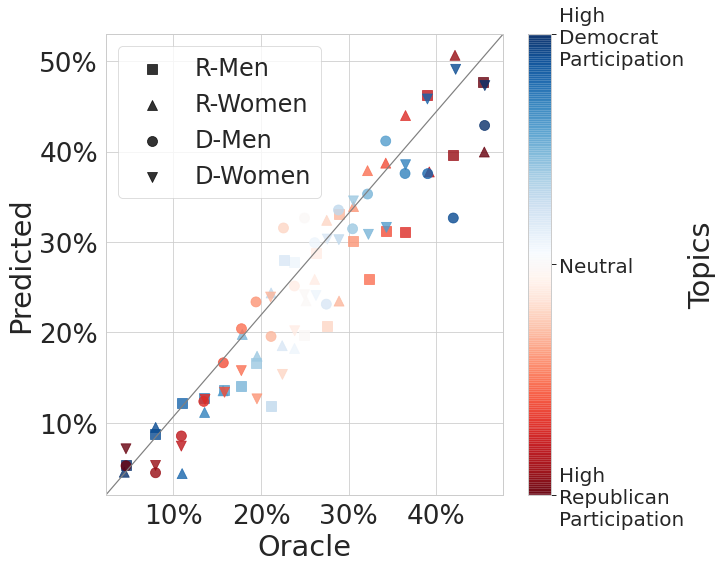

In [25]:
# plot figure
markers = ['s','o','^','v']
fig,ax = plt.subplots(nrows=1, ncols=1,sharex=True,sharey=True,figsize=(10,8))
cm1 = plt.cm.Reds_r(np.linspace(0, 1, 10))
cm2 = plt.cm.Blues(np.linspace(0, 1, 10))
cmfull = np.vstack((cm1,cm2))
cmfullmap = mcolors.LinearSegmentedColormap.from_list('span', cmfull)
for _i in range(2):
    for dem_ind in range(num_demographics):
        m = markers[dem_ind*2 + _i]
        sc = ax.scatter(
            100*res_p_df.loc[:,'dem{}_ideol{}_true'.format(dem_ind+1,_i)],
                        100*res_p_df.loc[:,'dem{}_ideol{}_pred'.format(dem_ind+1,_i)],
            c=res_p_df.index.values,s=100,marker=m,alpha=0.8,cmap=cmfullmap
        )
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_xticks([10,20,30,40])
leg = ax.legend(['R-Men','R-Women','D-Men','D-Women'],ncol=1,fontsize=24)
for i in range(4):
    leg.legendHandles[i].set_color('black')
cbar = plt.colorbar(sc, ticks=[-0.9, 0, 0.9],label='Topics',orientation='vertical')
cbar.ax.set_yticklabels(['High\nRepublican\nParticipation', 'Neutral', 'High\nDemocrat\nParticipation'],
                       fontsize=20)

ax.plot([0, 1], [0, 1], transform=ax.transAxes,c='gray',alpha=1)
ax.set_xlabel('Oracle')
ax.set_ylabel('Predicted')
plt.tight_layout()
